In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)


In [2]:
path = '../input/titanic/train.csv'
df = pd.read_csv(path) # titanic_fullsample
print(df.head())
print(df.shape)

df.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)
df.loc[df.Age.isnull(),'Age'] = df.Age.median()

print(df.describe())

   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S
(891, 12)
       PassengerId    Survived      Pclass         Age       SibSp

In [3]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
print(df.describe())

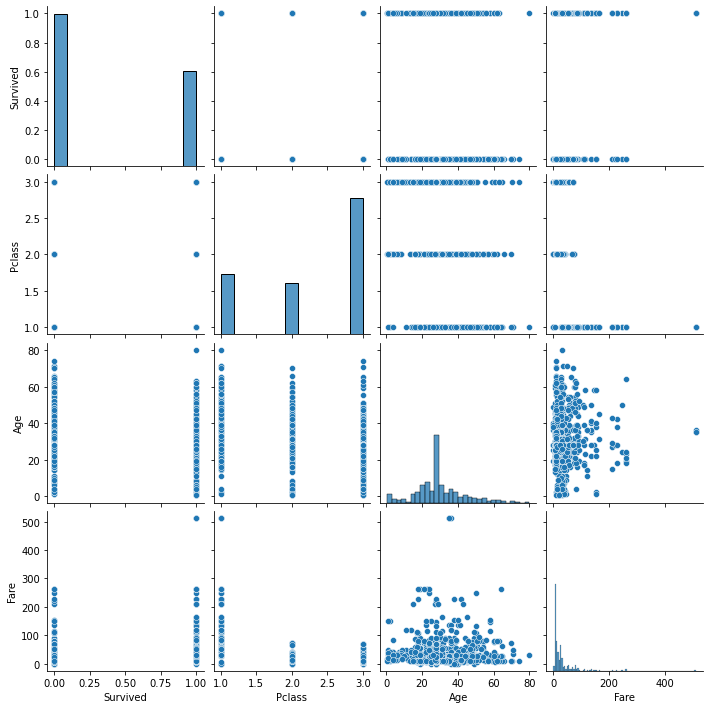

In [7]:
sns.pairplot(df[['Survived', 'Pclass', 'Age', 'Fare']])

In [ ]:
#%% Encode categorical variables ###

df.loc[df.SibSp>2,'SibSp']=3
df.loc[df.Parch>2,'Parch']=3

df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
numeric_variables = list(set(df.columns) - set(categorical_variables) - set(binary_variables))

lb = LabelBinarizer()
binary_variables.remove('Survived')

for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

print(df.head(10))

In [ ]:
# %% scaling ###

y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

mm = MinMaxScaler()

for column in [numeric_variables]:
    X_train[column] = mm.fit_transform(X_train[column])
    X_test[column] = mm.fit_transform(X_test[column])

In [ ]:
#%% Logistic regression ###

grid_values = {'penalty': ['l2'], 'C': list(np.arange(1,10.5,0.5))}
lr = LogisticRegression()
model_lr = GridSearchCV(lr, param_grid=grid_values, cv = 20)
model_lr.fit(X_train, y_train)
print(model_lr.best_score_, model_lr.best_params_)

# model_lr.predict(X_test)

In [ ]:
#%% KNN ###

grid_values = dict(n_neighbors=np.arange(1,40))
knnm = KNeighborsClassifier()   
model_knn = GridSearchCV(knnm, param_grid=grid_values, cv = 20)
model_knn.fit(X_train, y_train)
print(model_knn.best_score_, model_knn.best_params_)

In [ ]:
#%% SVM ###

grid_values = {'C': np.arange(0.05, 1, 0.05)} 
svmm = svm.SVC(kernel='rbf')
model_svm = GridSearchCV(svmm, param_grid=grid_values, cv = 20)
model_svm.fit(X_train, y_train)
print(model_svm.best_score_, model_svm.best_params_)

In [ ]:
#%% RF ###

# may look here: https://www.geeksforgeeks.org/hyperparameter-tuning/

grid_values = [{'max_depth': list(range(2, 9)), 'max_features': list(np.arange(0.2,0.71,0.05))}]
rfc = RandomForestClassifier(random_state=42)
model_rf = GridSearchCV(rfc, grid_values, cv = 20, scoring='accuracy')
model_rf.fit(X_train, y_train)
print(model_rf.best_score_, model_rf.best_params_)

In [ ]:
#%% XGBoost? ###
# run this code only on Kaggle with GPU

estimator = XGBClassifier(
    nthread=4,
    seed=42,
    use_label_encoder=False
)

parameters = {
    'max_depth': range (2, 5, 1),
    'n_estimators': range(5, 50, 5),
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train, eval_metric='rmse')
print(grid_search.best_score_, grid_search.best_params_)

In [ ]:
# evaluate performance oos

yhat_lm = model_lr.predict(X_test)
yhat_knn = model_knn.predict(X_test)
yhat_svm = model_svm.predict(X_test)
yhat_rf = model_rf.predict(X_test)
yhat_bt = grid_search.predict(X_test)
print('Accuracy of logistic regression is ', 1-(np.abs(yhat_lm-y_test)).mean())
print('Accuracy of KNN is ', 1-(np.abs(yhat_knn-y_test)).mean())
print('Accuracy of SVM is ', 1-(np.abs(yhat_svm-y_test)).mean())
print('Accuracy of RF is ', 1-(np.abs(yhat_rf-y_test)).mean())
print('Accuracy of Boosted Tree is ', 1-(np.abs(yhat_bt-y_test)).mean())